In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Introduction

need to do

# Data

The dataset I chose to explore is the famous Titanic dataset.  The dataset can be found here, https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html



In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare'],
      dtype='object')

In [4]:
df.drop('Name', axis=1, inplace=True)

In [5]:
df.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [6]:
df.isnull().sum()

Survived                   0
Pclass                     0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [7]:
df = pd.get_dummies(df)

In [8]:
y = df['Survived']

In [9]:
df.head()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1


# Initial 2D view of the dataset using UMAP

I'm setting n-companents equal to 2 and leaving the rest of the parameters as their defaults

In [11]:
X_initial = StandardScaler().fit_transform(df)

In [16]:
umap2 = UMAP(n_components=2)

In [17]:
X_initial_2d = umap2.fit_transform(X_initial)

<AxesSubplot:>

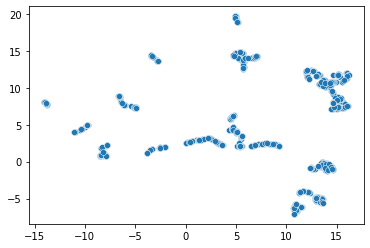

In [18]:
sns.scatterplot(x=X_initial_2d[:,0],y=X_initial_2d[:,1])

Although nothing can be inferred, there appear to be ten or more clusters.

# Clustering all data using KMeans

* use inertia to find the best k or k values
* Check consistency
* Look at silhouette score

In [13]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))


<AxesSubplot:>

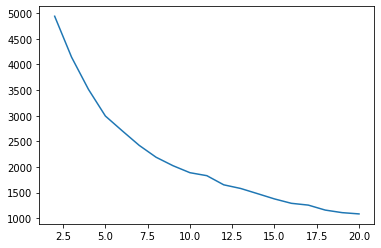

In [14]:
sns.lineplot(x=results[0],y=results[1])

It is hard to see an elbow.  I would say 11